In [1]:
# https://nsidc.org/data/smap_l1_l3_anc_static/versions/1
import numpy as np
import xarray as xr
import netCDF4
import matplotlib.pyplot as plt
import numpy.ma as ma
import pandas as pd
import os
from datetime import datetime
import glob
from tqdm import tqdm

# Configuration

In [2]:
data_dir = r"G:\Araki\SMSigxSMAP\1_data"
SMAPL3_dir = "SPL3SMP"
datarods_dir = "datarods"
SMAPL4_dir = "SPL4SMGP"
SMAPL4_grid_dir = "SMAPL4SMGP_EASEreference"
PET_dir = "PET"
SMAPL3_grid_sample = os.path.join(data_dir, r"SPL3SMP\SMAP_L3_SM_P_20150331_R18290_001.h5")

# Investigate netCDF4 file

In [3]:
ncf = netCDF4.Dataset(SMAPL3_grid_sample, diskless=True, persist=False)
nch_am = ncf.groups.get('Soil_Moisture_Retrieval_Data_AM')
nch_pm = ncf.groups.get('Soil_Moisture_Retrieval_Data_PM')

In [4]:
nch_am.variables

{'EASE_column_index': <class 'netCDF4._netCDF4.Variable'>
 uint16 EASE_column_index(phony_dim_0, phony_dim_1)
     long_name: The column index of the 36 km EASE grid cell that contains the associated data.
     coordinates: /Soil_Moisture_Retrieval_Data_AM/latitude /Soil_Moisture_Retrieval_Data_AM/longitude
     valid_min: 0
     valid_max: 963
     _FillValue: 65534
 path = /Soil_Moisture_Retrieval_Data_AM
 unlimited dimensions: 
 current shape = (406, 964)
 filling off,
 'EASE_row_index': <class 'netCDF4._netCDF4.Variable'>
 uint16 EASE_row_index(phony_dim_0, phony_dim_1)
     long_name: The row index of the 36 km EASE grid cell that contains the associated data.
     coordinates: /Soil_Moisture_Retrieval_Data_AM/latitude /Soil_Moisture_Retrieval_Data_AM/longitude
     valid_min: 0
     valid_max: 405
     _FillValue: 65534
 path = /Soil_Moisture_Retrieval_Data_AM
 unlimited dimensions: 
 current shape = (406, 964)
 filling off,
 'albedo': <class 'netCDF4._netCDF4.Variable'>
 float32

In [5]:
nch_pm.variables

{'EASE_column_index_pm': <class 'netCDF4._netCDF4.Variable'>
 uint16 EASE_column_index_pm(phony_dim_3, phony_dim_4)
     long_name: The column index of the 36 km EASE grid cell that contains the associated data.
     coordinates: /Soil_Moisture_Retrieval_Data_AM/latitude /Soil_Moisture_Retrieval_Data_AM/longitude
     valid_min: 0
     valid_max: 963
     _FillValue: 65534
 path = /Soil_Moisture_Retrieval_Data_PM
 unlimited dimensions: 
 current shape = (406, 964)
 filling off,
 'EASE_row_index_pm': <class 'netCDF4._netCDF4.Variable'>
 uint16 EASE_row_index_pm(phony_dim_3, phony_dim_4)
     long_name: The row index of the 36 km EASE grid cell that contains the associated data.
     coordinates: /Soil_Moisture_Retrieval_Data_AM/latitude /Soil_Moisture_Retrieval_Data_AM/longitude
     valid_min: 0
     valid_max: 405
     _FillValue: 65534
 path = /Soil_Moisture_Retrieval_Data_PM
 unlimited dimensions: 
 current shape = (406, 964)
 filling off,
 'albedo_dca_pm': <class 'netCDF4._netCDF4.

# Prepare geocoordinate matrix 

In [6]:
# Return as regular numpy array rather than masked array
_latitude = ma.getdata(nch_am.variables['latitude'][:].filled(fill_value=np.nan), subok=True)
_longitude = ma.getdata(nch_am.variables['longitude'][:].filled(fill_value=np.nan), subok=True)
_EASE_column_index = ma.getdata(nch_am.variables['EASE_column_index'][:].astype(int).filled(fill_value=-1), subok=True)
_EASE_row_index = ma.getdata(nch_am.variables['EASE_row_index'][:].astype(int).filled(fill_value=-1), subok=True)

In [7]:
# Coordinates with no data are skipped --- fill them
latitude = np.nanmax(_latitude, axis=1)
EASE_row_index = np.nanmax(_EASE_row_index, axis=1)
longitude = np.nanmax(_longitude, axis=0)
EASE_column_index = np.nanmax(_EASE_column_index, axis=0)

In [8]:
coord_info_column = pd.DataFrame({"latitude":latitude, "EASE_column_index":EASE_row_index})
coord_info_row = pd.DataFrame({"longitude":longitude, "EASE_row_index":EASE_column_index})
coord_info_column.to_csv(os.path.join(data_dir, 'coord_info_unique_column.csv'), index=False)
coord_info_row.to_csv(os.path.join(data_dir, 'coord_info_unique_row.csv'),  index=False)
coord_info = coord_info_row.assign(key=1).merge(coord_info_column.assign(key=1), on='key').drop('key', axis=1)
coord_info.index.name = 'id'
coord_info.to_csv(os.path.join(data_dir, 'coord_info.csv'))

In [9]:
# Get a list of files 
SMAPL3_fn_pattern = f'SMAP_L3_SM_P_*.h5'
SMAPL3_file_paths = glob.glob(rf'{data_dir}/{SMAPL3_dir}/{SMAPL3_fn_pattern}')
print(f"{SMAPL3_fn_pattern}: {len(SMAPL3_file_paths)} ... {len(SMAPL3_file_paths)/365:.1f} yrs of data available")

SMAP_L3_SM_P_*.h5: 2675 ... 7.3 yrs of data available


In [10]:
_ds_SMAPL3 = xr.open_dataset(SMAPL3_file_paths[0], engine='rasterio', group='Soil_Moisture_Retrieval_Data_AM', variable=['soil_moisture'])
ds_SMAPL3_coord_template = _ds_SMAPL3.assign_coords({'x':longitude, 'y':latitude}).rio.write_crs("epsg:4326")
ds_SMAPL3_coord_template

<xarray.Dataset>
Dimensions:                                        (band: 1, y: 406, x: 964)
Coordinates:
  * band                                           (band) int32 1
  * x                                              (x) float32 -179.8 ... 179.8
  * y                                              (y) float32 83.63 ... -83.63
    spatial_ref                                    int32 0
Data variables:
    Soil_Moisture_Retrieval_Data_AM_soil_moisture  (band, y, x) float32 ...
Attributes: (12/698)
    Metadata_AcquisitionInformation_platformDocument_edition:                ...
    Metadata_AcquisitionInformation_platformDocument_publicationDate:        ...
    Metadata_AcquisitionInformation_platformDocument_title:                  ...
    Metadata_AcquisitionInformation_platform_antennaRotationRate:            ...
    Metadata_AcquisitionInformation_platform_description:                    ...
    Metadata_AcquisitionInformation_platform_identifier:                     ...
    ...                                                                          ...
    Soil_Moisture_Retrieval_Data_PM_vegetation_water_content_pm_coordinates: ...
    Soil_Moisture_Retrieval_Data_PM_vegetation_water_content_pm_long_name:   ...
    Soil_Moisture_Retrieval_Data_PM_vegetation_water_content_pm_units:       ...
    Soil_Moisture_Retrieval_Data_PM_vegetation_water_content_pm_valid_max:   ...
    Soil_Moisture_Retrieval_Data_PM_vegetation_water_content_pm_valid_min:   ...
    Soil_Moisture_Retrieval_Data_PM_vegetation_water_content_pm__FillValue:  ...

# Process SMAP L4 precip data

## Read SMAP L4 data

In [11]:
from rasterio.enums import Resampling

In [12]:
# Re-assign x and y coordinates
SMAPL4_template_fn = r"G:\Araki\SMSigxSMAP\1_data\SPL4SMGP\SMAP_L4_SM_gph_20180911T103000_Vv7032_001_HEGOUT.nc"
SMAPL4_template = xr.open_dataset(SMAPL4_template_fn)

In [21]:
def preprocess_SMAPL4(ds):
    # Assign missing time dimension
    startTime = datetime.strptime(ds.rangeBeginningDateTime.split(".")[0], '%Y-%m-%dT%H:%M:%S')
    endTime = datetime.strptime(ds.rangeEndingDateTime.split(".")[0], '%Y-%m-%dT%H:%M:%S')
    midTime = startTime + (startTime - endTime)/2
    ds = ds.assign_coords(time=midTime)

    # Reassign coordinates 
    ds = ds.assign_coords(x=SMAPL4_template['x'][:], y=SMAPL4_template['y'][:]*(-1))

    # Resample according to SMAPL3 grid
    ds.rio.write_crs('epsg:4326', inplace=True)
    ds_SAMPL4_resampled = ds.sel(band=1).rio.reproject_match(ds_SMAPL3_coord_template.sel(band=1), resampling=Resampling.average)

    # Fillnan 
    _FillValue = _FillValue = 3.4028235e+38
    ds_SMAPL4_3hrly = ds_SAMPL4_resampled.where(ds_SAMPL4_resampled.precipitation_total_surface_flux != _FillValue, np.nan)
    
    return ds_SMAPL4_3hrly

In [22]:
chunks = {'x': 1200, 'y': 1200, 'time':1, 'band':1}
SMAPL4_fn_pattern = f'SMAP_L4_SM_gph_201610*.nc'
SMAPL4_file_paths = glob.glob(rf'{data_dir}/{SMAPL4_dir}/{SMAPL4_fn_pattern}')
print(f"{SMAPL4_fn_pattern}: {len(SMAPL4_file_paths)} ... {len(SMAPL4_file_paths)/6/365:.1f} yrs of data available")
# file_path = r"G:\Araki\SMSigxSMAP\1_data\SPL4SMGP\SMAP_L4_SM_gph_20150331T013000_Vv7032_001_HEGOUT.nc"
# ds_SMAPL4_3hrly = xr.open_mfdataset(file_path, group='Geophysical_Data', engine="rasterio", preprocess=preprocess_SMAPL4, chunks=chunks)
# ds_SMAPL4_3hrly
# ds_SMAPL4_3hrly = xr.open_mfdataset(SMAPL4_file_paths, group='Geophysical_Data', engine="rasterio", preprocess=preprocess_SMAPL4, chunks=chunks)

SMAP_L4_SM_gph_201610*.nc: 248 ... 0.1 yrs of data available


In [25]:
# Get a list of files 
# Load dataset
import warnings
warnings.filterwarnings("ignore")

_ds_SMAPL4_list = []
for filename in tqdm(SMAPL4_file_paths):
    try:
        _ds_SMAPL4 = xr.open_dataset(filename, group='Geophysical_Data', engine="rasterio")
        _ds_SMAPL4 = preprocess_SMAPL4(_ds_SMAPL4)
        if 'ds_SMAPL4' in locals():
            ds_SMAPL4 = xr.concat([ds_SMAPL4, _ds_SMAPL4], dim="time")
        else:
            ds_SMAPL4 = _ds_SMAPL4
    except Exception as e:
        print(f"An error occurred: {e}")
        continue
# _ds_SMAPL4_list_stacked = xr.concat(_ds_SMAPL4_list, dim='time')
# Cannot use open_mfdataset --- can't skip if there is error

 36%|███▋      | 90/248 [00:40<01:16,  2.08it/s]

In [129]:

# Resample to daily
ds_SMAPL4 = ds_SMAPL4_3hrly.resample(time='D', skipna=True, keep_attrs=True).mean()

## Resample to SMAPL3 grid

In [133]:

from rasterio.enums import Resampling
ds_SAMPL4_resampled = ds_SMAPL4.sel(band=1).rio.reproject_match(ds_SMAPL3_coord_template.sel(band=1), resampling=Resampling.average)
ds_SAMPL4_resampled

c:\Users\raraki8159\.conda\envs\SMAP_v2\Lib\site-packages\xarray\core\common.py:936: UserWarning: Passing ``keep_attrs`` to ``resample`` has no effect and will raise an error in xarray 0.20. Pass ``keep_attrs`` directly to the applied function, e.g. ``resample(...).mean(keep_attrs=True)``.
  warnings.warn(


<xarray.Dataset>
Dimensions:                           (time: 32, band: 1, y: 1822, x: 3856)
Coordinates:
  * band                              (band) int32 1
  * x                                 (x) float64 -180.0 -179.9 ... 179.9 180.0
  * y                                 (y) float64 -85.0 -84.9 ... 84.92 85.01
    projection_information            int32 0
  * time                              (time) datetime64[ns] 2016-09-30 ... 20...
    spatial_ref                       int32 0
Data variables:
    precipitation_total_surface_flux  (time, band, y, x) float32 nan nan ... nan
Attributes: (12/201)
    antennaRotationRate:                13
    description:                        The observation-corrected surface met...
    identifier:                         GEOS5COR
    edition:                            JPL CL#14-2285, JPL 400-1567
    publicationDate:                    2014-07-01
    title:                              SMAP Handbook
    ...                                 ...
    grid_rows:                          1822
    History:                            File written by ldas2daac.x
    Institution:                        NASA Global Modeling and Assimilation...
    References:                         see SMAP L4_SM Product Specification ...
    Source:                             v17.11.1
    Title:                              SMAP L4_SM Geophysical (GPH) Data Gra...

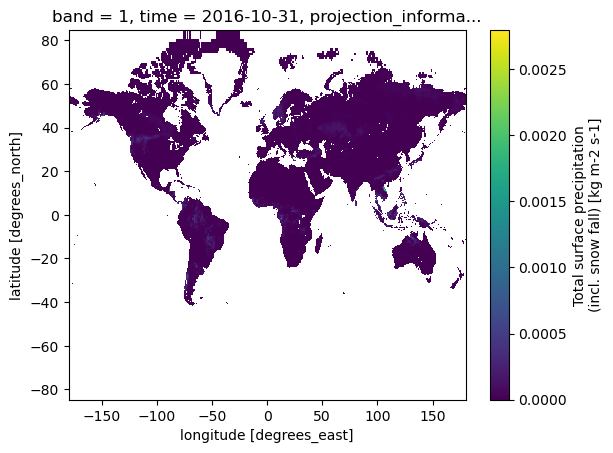

In [145]:
ds_SAMPL4_resampled.precipitation_total_surface_flux.sel(time="2016-10-31").plot()

In [163]:
# Can combine all data together --- but memory is not enough
# combined_ds = _ds_SMAPL3_list_stacked.sel(band=1)
# combined_ds["precipitation_total_surface_flux"] = ds_SAMPL4_resampled.precipitation_total_surface_flux

## Create datarods

In [ ]:
# Create and save the datarods  
out_dir = os.path.join(data_dir, datarods_dir, SMAPL4_dir)
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

from itertools import product
print("CREATING SMAPL4 DATARODS")
for y_i, x_j in tqdm(product(EASE_row_index, EASE_column_index)):
    try:
        df_SMAPL3 = ds_SAMPL4_resampled.isel(x=x_j, y=y_i,band=0).to_dataframe().drop(['band', 'spatial_ref', 'projection_information'], axis=1)
        filename = f'{SMAPL4_dir}_{y_i:03}_{x_j:03}.csv'
        df_SMAPL3.to_csv(os.path.join(out_dir, filename))
    except Exception as e:
        print(f"An error occurred: {e}")
        continue